In [1]:
import pygmt

In [54]:
minlon, maxlon = -123.047755, -122.111954
minlat, maxlat = 47.8, 48.5
topo_data = '@earth_relief_03s' #3 arc second global relief (SRTM3S)
pygmt.config(FONT='ARIAL')

gmtset [WARNING]: Length <unit> L not supported - revert to default unit [point]
gmtset [WARNING]: ARIA not a valid number and may not be decoded properly.
gmtset [WARNING]: Representation of font size not recognized. Using default.
gmtset [WARNING]: Length <unit> L not supported - revert to default unit [point]
gmtset [WARNING]: ARIA not a valid number and may not be decoded properly.
gmtset [WARNING]: Representation of font size not recognized. Using default.
gmtset [WARNING]: Length <unit> L not supported - revert to default unit [point]
gmtset [WARNING]: ARIA not a valid number and may not be decoded properly.
gmtset [WARNING]: Representation of font size not recognized. Using default.
gmtset [WARNING]: Length <unit> L not supported - revert to default unit [point]
gmtset [WARNING]: ARIA not a valid number and may not be decoded properly.
gmtset [WARNING]: Representation of font size not recognized. Using default.
gmtset [WARNING]: Length <unit> L not supported - revert to default 

In [66]:
# make color pallets
pygmt.makecpt(
    cmap='topo',
    series='-8000/8000/1000',
    continuous=True
)

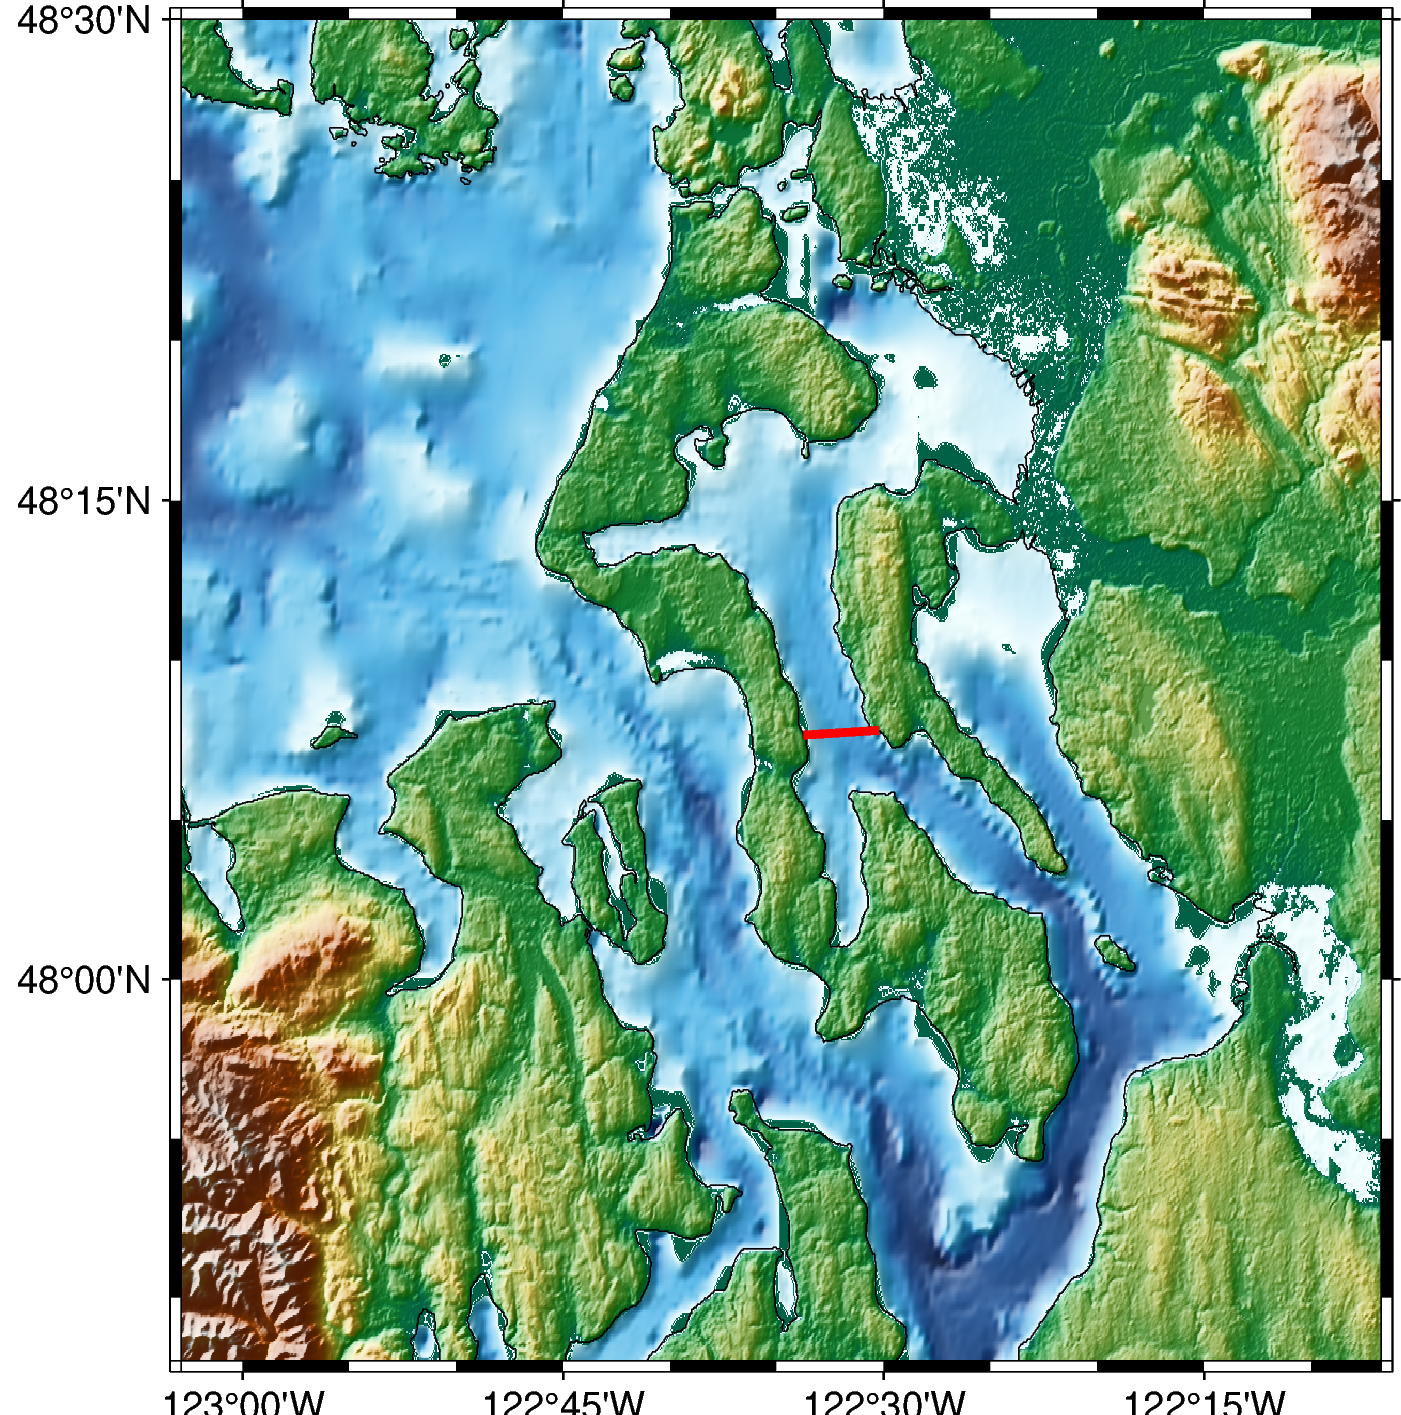

In [67]:
fig = pygmt.Figure()

fig.grdimage(
    grid=topo_data,
    region=[minlon, maxlon, minlat, maxlat],
    projection='M4i',
    shading=True
    )

fig.coast(
    region=[minlon, maxlon, minlat, maxlat],
    projection='M4i',
    shorelines=True,
    frame=True,
    rivers=10
    )

fig.plot(
    region=[minlon, maxlon, minlat, maxlat],
    projection='M4i',
    x=[-122.562266, -122.503804],
    y=[48.127646, 48.130110],
    pen="2p,red",
)

fig.show()

In [77]:
import pandas as pd
the_goods =  pd.read_csv("fk_10min.csv")

In [79]:
import numpy as np
import pygmt
import xarray as xr


# # Define an interesting function of two variables, see:
# # https://en.wikipedia.org/wiki/Ackley_function
# def ackley(x, y):
#     return (
#         -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
#         - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))
#         + np.exp(1)
#         + 20
#     )


# # Create gridded data
# INC = 0.05
x = np.arange(-5, 5 + INC, INC)
y = np.arange(-5, 5 + INC, INC)
data = xr.DataArray(ackley(*np.meshgrid(x, y)), coords=(x, y))

fig = pygmt.Figure()

# Plot grid as a 3-D surface
SCALE = 0.5  # in centimeters
fig.grdview(
    "fk_10min.csv"
)

# fig.grdview(
#     the_goods,
#     # Set annotations and gridlines in steps of five, and
#     # tick marks in steps of one
#     frame=["a5f1g5", "za5f1g5"],
#     projection=f"x{SCALE}c",
#     zscale=f"{SCALE}c",
#     surftype="s",
#     cmap="roma",
#     perspective=[135, 30],  # Azimuth southeast (135°), at elevation 30°
#     shading="+a45",
# )

# Add colorbar for gridded data
# fig.colorbar(
#     frame="a2f1",  # Set annotations in steps of two, tick marks in steps of one
#     position="JRM",  # Place colorbar at position Right Middle
# )

fig.show()

pygmt-session (gmtapi_import_grid): Not a supported grid format [fk_10min.csv]ERROR 4: `fk_10min.csv' not recognized as a supported file format.

[Session pygmt-session (237)]: Error returned from GMT API: GMT_GRID_READ_ERROR (18)
[Session pygmt-session (237)]: Error returned from GMT API: GMT_GRID_READ_ERROR (18)
grdview [ERROR]: Option -R parsing failure. Correct syntax:

-R<west>/<east>/<south>/<north>[+r]
Specify the min/max coordinates of your data region in user units. Use dd:mm[:ss] for regions
     given in arc degrees, minutes [and seconds]. Use -R<xmin>/<xmax>/<ymin>/<ymax>[+u<unit>] for
     regions given in projected coordinates, with <unit> selected from e|f|k|M|n|u [e]. If +u is
     set, projected regions centered on (0,0) may beset via -R<halfwidth>[/<halfheight>]+u<unit>,
     where <halfheight> defaults to <halfwidth> if not given. Use
     [yyyy[-mm[-dd]]]T[hh[:mm[:ss[.xxx]]]] format for time axes. Append +r if -R specifies the
     coordinates of the lower left and 

GMTCLibError: Module 'grdview' failed with status code 72:
grdview [ERROR]: Option -R parsing failure. Correct syntax:
grdview [ERROR]: Offending option -R0/0/0/0